# Energy estimation by Kernel Ridge Regression
We will predict energies on a dataset of ab initio molecular dynamics (AIMD) trajectories using a Kernel Ridge Regression (KRR) model trained directly on the energies.

The dataset contains $M = 50000$ recordings of energy for the $\text{H}_2 \text{O}_2$ molecule, along with the 3d coordinates of each atom for each recording. As such, our input data $X$ is of shape $(50000, 4, 3)$ For speed, we will only be using subsets of the dataset for training.


In [2]:
import numpy as np
data = np.load('data/HOOH.DFT.PBE-TS.light.MD.500K.50k.R_E_F_D_Q.npz')
X = data['R']
y = data['E']
X.shape, y.shape

((50000, 4, 3), (50000, 1))

## KRR model
The KRR predictor is given by
$$ \hat{y} = f(\mathbf{x}) = \sum_{i=1}^M \alpha_i k_{\phi}(\mathbf{x}, \mathbf{x}_i) $$
with 
$\alpha = (\mathbf{K} - \lambda I)^{-1} \mathbf{y}$ and $\mathbf{K}_{i,j} = k_{\phi}(\mathbf{x}_i, \mathbf{x}_j)$
for a *kernel function* $k_{\phi}$ which is an inner product in the feature space given by our choice of feature map $\phi$.

### Feature descriptor
To encode the geometries in a way that is invariant to rotation and translation [[1]](https://link.springer.com/chapter/10.1007/978-3-030-30493-5_75) we use a feature descriptor inspired by the Coulomb matrix [[2]](https://advances.sciencemag.org/content/3/5/e1603015), but simplified given that each entry of our dataset represents the same molecule. For input positions $\mathbf{x} = (R_i)_{i \in \{1,\ldots,4\}}$ with $R_i \in \mathbb{R}^3$ the descriptor $D$ is given by
$$
D_{ij} = 
\left\{
	\begin{array}{ll}
		\| R_i - R_j \|^{-1}  & \mbox{for } i \gt j \\
		0 & \mbox{for } i \leq j
	\end{array}
\right.
$$


In [3]:
def descriptor(x):
    atoms, dimension = x.shape
    D = np.zeros((atoms, atoms))
    for i in range(atoms):
        for j in range(atoms):
            if i > j:
                D[i, j] = 1 / np.linalg.norm(x[i] - x[j])
            else:
                D[i, j] = 0
    return D.flatten()

### kernel function
as a kernel function we will use a Gaussian kernel $$k(\mathbf{d}, \mathbf{d}') = \text{exp}({-\frac{\|\mathbf{d} - \mathbf{d'} \|} {\sigma}})$$
for flattened feature descriptors $\mathbf{d}, \mathbf{d}'$
As computing this kernel separately on every pair of inputs would be slow, we will compute the matrix $\mathbf{K}$ and the function $k^*(\mathbf{x}) = \sum_{\mathbf{x}'} k_{\phi}(\mathbf{x}, \mathbf{x}')$ by first computing the pairwise distances using scipy.

In [5]:
from scipy.spatial.distance import pdist, cdist, squareform


def gaussian(data, sigma=1):
    X = [descriptor(x) for x in data]
    dists = squareform(pdist(X, 'euclidean'))
    return np.exp(-dists ** 2 / sigma)

def kstar(input, data, sigma=1):
    x = np.array([descriptor(x_) for x_ in input])
    X = np.array([descriptor(x_) for x_ in data])
    dists = cdist(x, X)
    kstar = np.exp(-dists ** 2 / sigma)
    return kstar

In [6]:
K = gaussian(X[:1000])
K.shape

(1000, 1000)

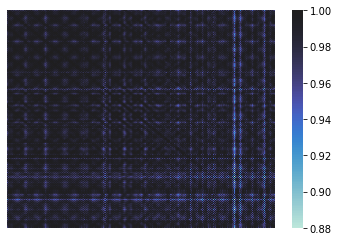

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.heatmap(K, center=1, vmin=0.88, xticklabels=False, yticklabels=False)
plt.show()

To train the model we will use the scikit-learn interface for KRR. This will allow us to search over parameters later. The following code integrates our feature map and kernel into the sklearn class.

In [8]:
from sklearn.kernel_ridge import KernelRidge

class GaussianKRR(KernelRidge):

    def __init__(self, sigma=1):
        self.alpha = 1e-15
        self.sigma = sigma
        self.kernel = None

    def _validate_data(self, X, y, **_):
        return X, y

    def _get_kernel(self, X, Y=None):
        if Y is not None:
            return kstar(X, Y, sigma=self.sigma)
        else:
            return gaussian(X, sigma=self.sigma)

    def fit(self, X, y):
        K = self._get_kernel(X)
        y = y.reshape(-1, 1)
        ravel = True
        

        n_samples = K.shape[0]
        K.flat[::n_samples + 1] += self.alpha
        self.dual_coef_ = np.linalg.solve(K, y)
        self.dual_coef_ = self.dual_coef_.ravel()

        self.X_fit_ = X

        return self

In [9]:
model = GaussianKRR(sigma=1)
model.fit(X[:1000], y[:1000])
test = slice(20000, 21000)
yhat = model.predict(X[test])
np.mean(np.abs(yhat - y[test]))

4.787288656273159

## Parameter search
Our elementary choice of parameters $\lambda = 10^{-15}$ and $\sigma=1$ yielded good test performance even when trained only on 1000 samples or 2% of the data. Let's now take a systematic approach to finding the best $\sigma$. For that, we will use sklearn's cross-validation tool, which will tell us about the ability for each parametrization of the model to generalize.

In [10]:
from sklearn.model_selection import GridSearchCV
'''
parameters = {'sigma': [0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]}
cross_validation = GridSearchCV(GaussianKRR(), parameters)
cross_validation.fit(X[:10000], y[:10000])
results = cross_validation.cv_results_
results
'''

"\nparameters = {'sigma': [0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]}\ncross_validation = GridSearchCV(GaussianKRR(), parameters)\ncross_validation.fit(X[:10000], y[:10000])\nresults = cross_validation.cv_results_\nresults\n"

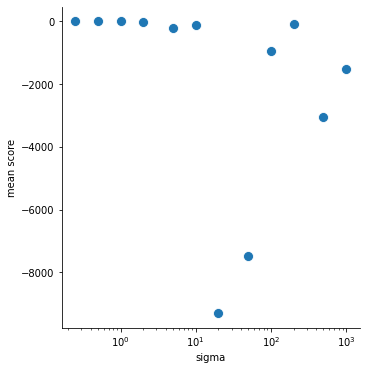

In [14]:
import pandas as pd
data = pd.DataFrame({'sigma': results['param_sigma'], 'mean score': results['mean_test_score']})
sns.relplot(x='sigma', y='mean score', data=data, s=100)
plt.xscale('log')
plt.show()

For training on 10000 samples (20% of the dataset) we have found the parametrization $\sigma = \frac{1}{2}$ to work best.

Let us now explore how a model thus parametrized improves in generalizability with an increase in training data.

In [28]:
data_subset_sizes = [100, 200, 500, 1000, 2000, 5000]
scores = []
test = slice(20000, 21000)
parameters = {'sigma': [0.25, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]}
for size in data_subset_sizes:
  
    cross_validation = GridSearchCV(GaussianKRR(), parameters)
    cross_validation.fit(X[:size], y[:size])
    results = cross_validation.cv_results_
    best = np.argmin(results['rank_test_score'])
    best_sigma = results['param_sigma'][best]
    print(f'Best sigma: {best_sigma}')
    best_mean_test_score = results['mean_test_score'][best]
    print(f'best mean test score: {best_mean_test_score}')
    scores.append(best_mean_test_score)

Best sigma: 500
best mean test score: 0.6933003664799346
Best sigma: 2
best mean test score: 0.9347045040011082
Best sigma: 0.5
best mean test score: 0.9959781411500053
Best sigma: 1
best mean test score: 0.9716133265728523
Best sigma: 0.5
best mean test score: 0.9522194277554237
Best sigma: 0.5
best mean test score: 0.88953431652213


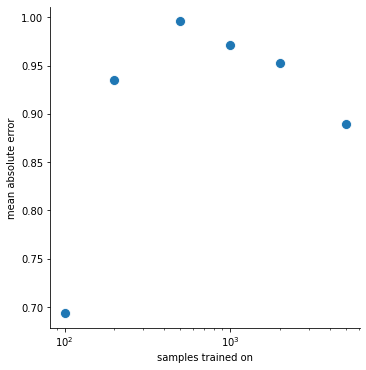

In [30]:
data = pd.DataFrame({'samples trained on': data_subset_sizes, 'mean absolute error': scores})
sns.relplot(x='samples trained on', y='mean absolute error', data=data, s=100)
plt.xscale('log')
plt.show()

We observe that, for this dataset, using more data under the same parametrization does not necessarily yield a better model. This means that, to find the optimal parameters, the cross-validation search should be performed directly on a dataset of a similar size to the one we will ultimately use.

To illustrate the learning of the model, we will compute its learning curve. The learning curve is the model's loss as a function of, for iteratively trained models, the number of training iterations, but, since we are computing an analytical solution, we see it as a function of the dataset size.

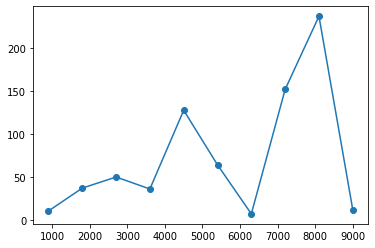

In [14]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = \
    learning_curve(GaussianKRR(sigma=1/2), X[:10000], y[:10000], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
plt.plot(train_sizes, -test_scores.mean(1), 'o-')
plt.show()

## Conclusion
In this work we predicted the energies of molecular trajectories using Kernel Ridge Regression. We found the best parameters for training on a subset of the data, and showed that the optimal parametrization depends on the dataset size.